# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.BayesianNN import PosteriorBNN
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_distributions, plot_history, plot_samples, plot_sampling_info, plot_divergences
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation
from Utils import plot_distribution

### Expectation Function

In [3]:
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

# Easy BNN Problem

## Specifiy target distribution and key param

In [4]:
torch.manual_seed(1)
target = PosteriorBNN(n_datapoints=2, x_dim=1, y_dim=1, n_hidden_layers=0, layer_width=0
                             ,linear_activations=True, fixed_variance=True, use_bias=True)

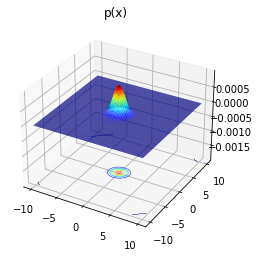

In [5]:
p_x_fig = plot_distribution(target, n_points=100)

## Setup

In [6]:
epochs = 1000
n_samples_estimation = int(1e4)
dim = target.n_parameters
print(dim)

2


## DReG
Let's instantiate a flow based model, and train using DReG

In [15]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

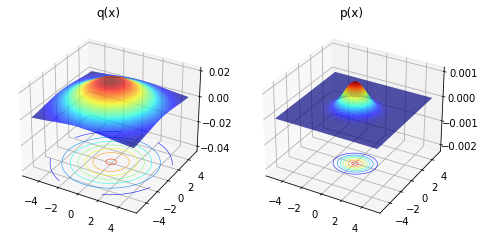

In [16]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

In [17]:
history = tester.train(400, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 3.6501212120056152, mean log p_x -13.743330001831055: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:35<00:00,  1.14s/it]


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>],
       dtype=object))

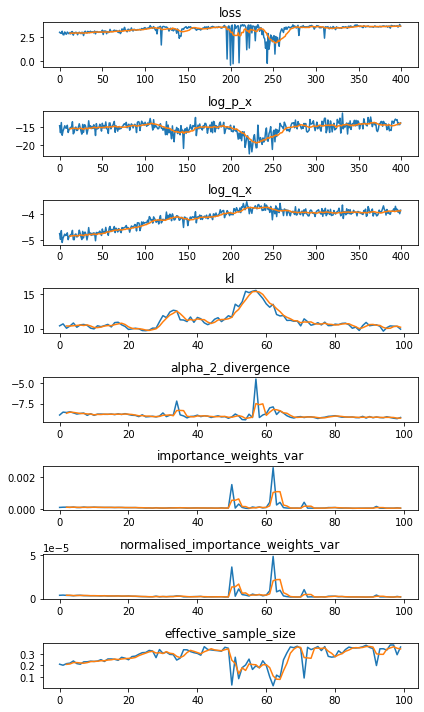

In [18]:
plot_history(history) #, bounds=[-1e4, 0])

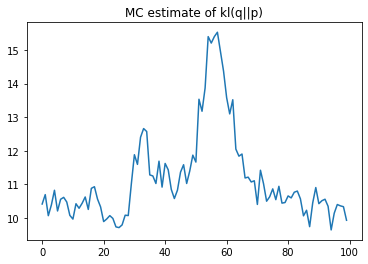

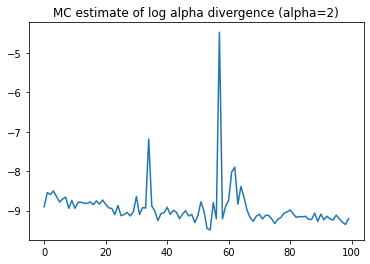

In [25]:
plot_divergences(history)

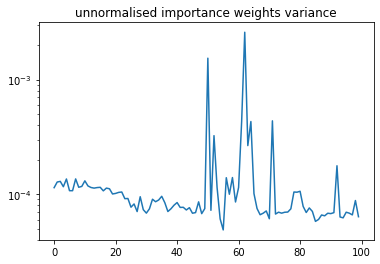

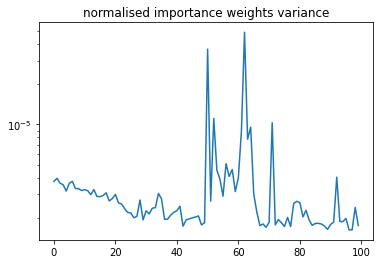

In [26]:
plot_sampling_info(history)

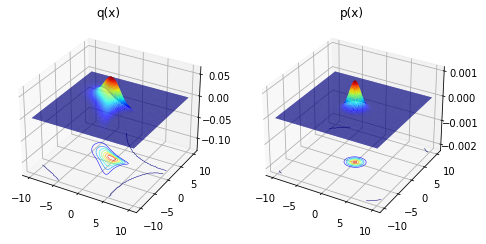

In [20]:
fig_after_train = plot_distributions(tester)

In [21]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 1.9519871473312378 
estimate after training is 1.9048794507980347 
effective sample size before is 2170.089599609375 out of 10000 
effective sample size after is 3641.827392578125 out of 10000  
variance in weights is 1.7460482837350355e-08


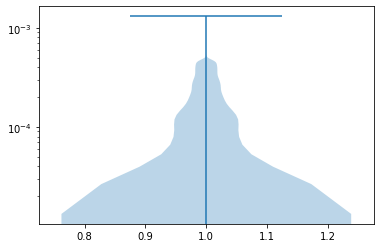

In [22]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

## KL

In [ ]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
history = tester.train(1000, batch_size=1000) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
plot_history(history, bounds=[-1e12, 1e12], running_chunk_n=10)

In [ ]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

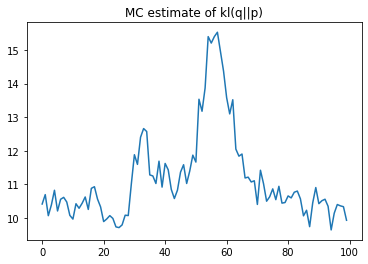

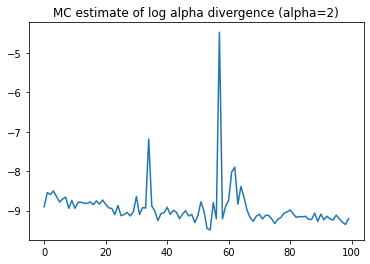

In [25]:
plot_divergences(history)

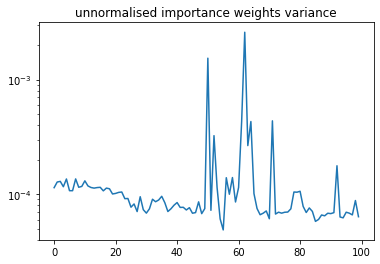

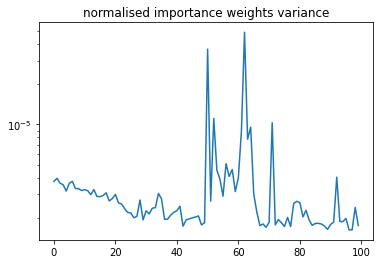

In [26]:
plot_sampling_info(history)

# Harder Problem

In [7]:
target = PosteriorBNN(n_datapoints=10, x_dim=2, y_dim=2, n_hidden_layers=1, layer_width=2)
epochs = 1000
n_samples_estimation = int(1e4)
dim = target.n_parameters
print(dim)

18


## DReG
Let's instantiate a flow based model, and train using DReG

In [10]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [11]:
history = tester.train(400, batch_size=1000, clip_grad=True, max_grad_norm=2)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: -3894.553466796875, mean log p_x -2.535292943988687e+18: 100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [22:44<00:00,  3.41s/it]


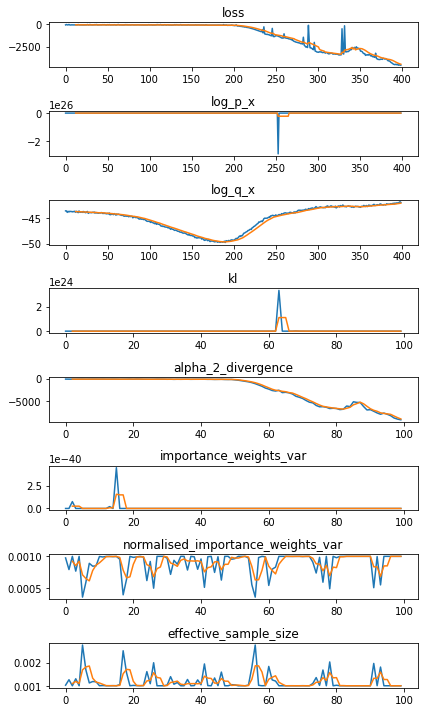

In [12]:
hist_plot = plot_history(history) #, bounds=[-1e4, 0])

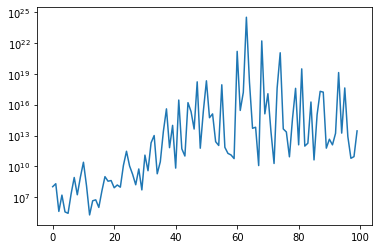

In [24]:
plt.figure()
plt.plot(history["kl"])
plt.yscale("log")

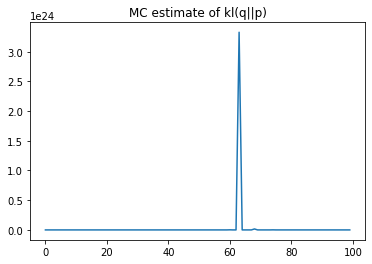

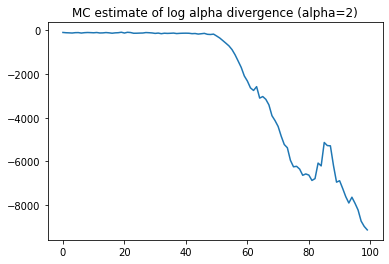

In [13]:
plot_divergences(history)

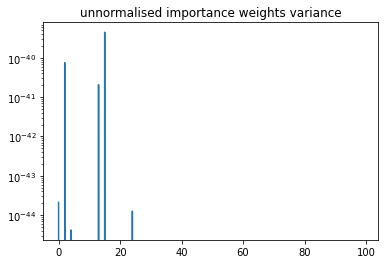

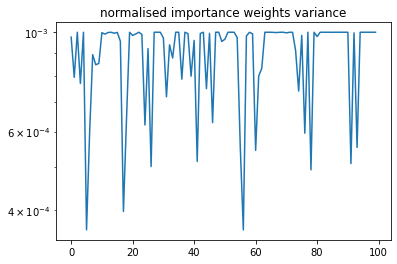

In [14]:
plot_sampling_info(history)

In [16]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 19.456451416015625 
estimate after training is 10902.53125 
effective sample size before is 1.0705790519714355 out of 10000 
effective sample size after is 2.049712896347046 out of 10000  
variance in weights is 4.878219624515623e-05


In [ ]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

## KL

In [25]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [26]:
history = tester.train(1000, batch_size=1000) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 53.72107696533203, mean log p_x -78.42893981933594: 100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [33:32<00:00,  2.01s/it]


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>],
       dtype=object))

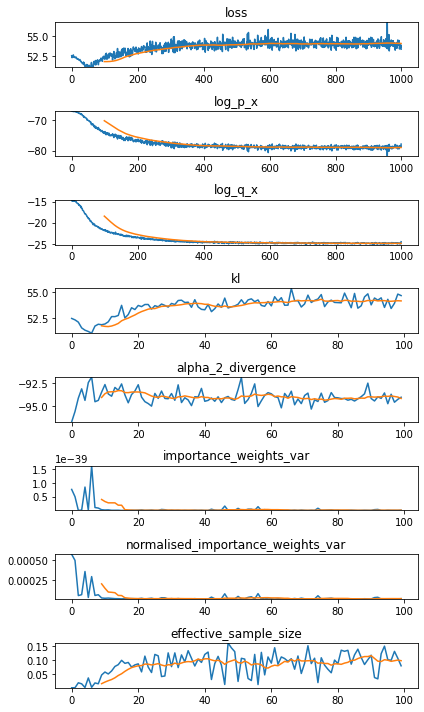

In [27]:
plot_history(history, bounds=[-1e12, 1e12], running_chunk_n=10)

In [28]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 17.961381912231445 
estimate after training is 15.089600563049316 
effective sample size before is 1.0705790519714355 out of 10000 
effective sample size after is 944.3468017578125 out of 10000  
variance in weights is 9.590286964566985e-08


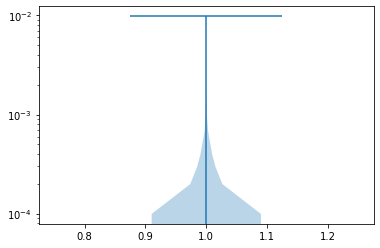

In [29]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

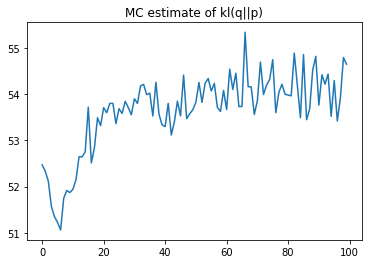

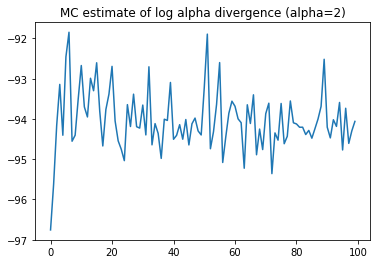

In [30]:
plot_divergences(history)